In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import ztest
%load_ext blackcellmagic

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [6]:
data = pd.read_csv("client_test.csv")
data.head()

,id_client,date_act,id_group,flag_order
0,101170,2021-01-06,1,1
1,100312,2021-03-04,1,0
2,101860,2021-02-14,0,1
3,100494,2021-02-11,1,1
4,102004,2021-01-17,1,1


In [18]:
data.shape

(2024, 4)

Найдём средние значения `flag_order` для каждой из групп.

In [4]:
data.drop("id_client", axis=1).groupby("id_group").mean()

In [7]:
groups = [data[data.id_group==0]['flag_order'], data[data.id_group==1]['flag_order']]

Код в блоке ниже выяснит правдивость гипотезы $H_0: \mu_0-\mu_1=0$. Альтернативная гипотеза $H_1: \mu_0 \neq \mu_1$

In [8]:
z, pval = ztest(np.array(groups[0]), np.array(groups[1]))
if pval < 0.05:
    print("we reject null hypothesis")
else:
    print("we accept null hypothesis")

Сменим теперь вид альтернативной гипотезы: $H_1: \mu_0 - \mu_1 > 0$

In [9]:
z, pval = ztest(np.array(groups[0]), np.array(groups[1]), alternative="larger")
if pval < 0.05:
    print("we reject null hypothesis")
else:
    print("we accept null hypothesis")

И наконец $H_1: \mu_0 - \mu_1 < 0$

In [10]:
z, pval = ztest(np.array(groups[0]), np.array(groups[1]), alternative="smaller")
if pval < 0.05:
    print("we reject null hypothesis")
else:
    print("we accept null hypothesis")

Отсюда следует, что люди, которым была дана скидка 15% охотнее пользуются этим предложением.

Чтобы отследить поведение уровня статистической значимости в зависимости от времени, будем записывать в отдельный список значения p-value рассчитанные для каждых последовательных пяти дней. Найдём для начала длину диапазона дат, который есть у нас в таблице.

In [13]:
data["date_act"] = data.date_act.apply(pd.to_datetime)
days_num = (data.date_act.max() - data.date_act.min()).days
days_num

90

Чтобы было удобнее работать с датами, преобразуем дату в её порядковый номер как дня в году.

In [14]:
data['date_act'] = data.date_act.apply(lambda x: x.dayofyear)

Отсортируем по возрастанию даты нашу таблицу

In [15]:
data.sort_values('date_act', inplace=True)

В данном цикле рассчитаем $p-value$ для каждой из подгрупп. Для этого выделим из отсортированного датафрейма тех клиентов, чьи заказы находились в интервале $[n, n+15)$ дней от начала эксперимента, где $n=1+15k$,   $k \in [0, 5]$,   $k \in \mathbb{N}_0$ (переменная `subset`)\
В списке `subgroups` будем хранить разделённые по `id_group` части `subset`\
Такое разбиение гарантирует нам что в каждой из подгрупп окажется не менее 30 строк


In [17]:
pvalues = []
for i in range(1, 91, 15):
    subset = data[(i <= data.date_act) & (data.date_act < i + 15)]
    subgroups = [
        subset[subset.id_group == 0]["flag_order"],
        subset[subset.id_group == 1]["flag_order"],
    ]
    z, pval = ztest(np.array(subgroups[0]), np.array(subgroups[1]))
    pvalues.append(pval)
pvalues

[0.024606727226869726,
 0.877321480106228,
 0.3053807240979657,
 0.5279187937155423,
 0.01834744004095173,
 0.11082664141766364]

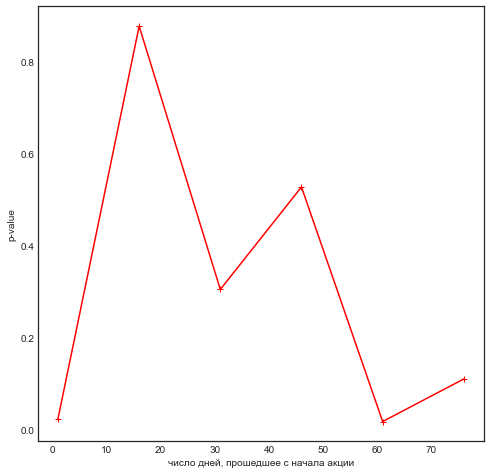

In [19]:
num_of_days = list(range(1, 91, 15))
fig = plt.figure(figsize=(8, 8))
plt.plot(num_of_days, pvalues, "r-+")
plt.ylabel("p-value")
plt.xlabel("число дней, прошедшее с начала акции")
plt.show()

Вопросы к коллегам:
1. Почему для проведения эксперимента было выбрано именно это время года?
2. В каких городах проходил эксперимент?
3. Каким критериям должен был отвечать клиент, чтобы попасть в ту или иную выборку?


Для того, чтобы произвести более глубокую сегментацию необходимо добавить следующие признаки:
1. Время показа акции и время заказа с точностью до часа (очевидно, что в утреннее время люди охотнее бы воспользовались скидкой на такси)
2. Город клиента
3. Класс такси